# Beating the Applicant Tracking System (ATS): Architect
This project idea first occurred to me when I was about to refine my resume. Most companies now use some sort of applicant tracking system (ATS) to filter out applicants whose resumes do not include enough of the "keywords" that matter to the job profile. Generally, people attempt to look through a few examples of job descriptions out there in order to arrive at an array of importants words or phrases that they must include in order to stand out. What they cannot do is look through potentially thousands of job descriptions and come up with a much more accurate, comprehensive list (and ranking!) of keywords tailored for the kind of job they are applying for. This is precisely the overarching goal of this project. 

## Part 0. Importing Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import itertools
from collections import Counter

# Web scraping
import requests
from bs4 import BeautifulSoup
import time

# NLP
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import os
os.environ.update({'MALLET_HOME':r'C:/new_mallet/mallet-2.0.8/'})
mallet_path = 'C:/new_mallet/mallet-2.0.8/bin/mallet'

# Other scikit-learn packages
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA

# Visualization
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

import warnings
warnings.filterwarnings("ignore")


## Part I. Data Acquisition

By default, we sort the jobs in order of relevance. Indeed has the tendency to sort chronologically after the sorting, which is also what we want. Also by default, we search within 25 km of the requested city of interest.

Let us define some helper functions. A big shout-out to this [medium post](https://medium.com/@msalmon00/web-scraping-job-postings-from-indeed-96bd588dcb4b) for already defining a number of useful functions for parsing html data.

In [2]:
NUM_PAGES = 100 # max. number of pages to search (1 page = ~20 jobs)

def extract_job_titles(soup): 
    jobs = []
    for div in soup.find_all(name='div', attrs={'class':'row'}):
        for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
            jobs.append(a['title'])
    return jobs

def extract_job_desc(soup):
    job_desc = []
    progress = 0
    for div in soup.find_all(name='div', attrs={'class':'title'}):
        for a in div.find_all(name='a'):
            # Enter the job description page
            job_desc_page = requests.get('https://indeed.ca/viewjob?jk=' + a['id'][3:])
            
            # Get description content
            desc = BeautifulSoup(job_desc_page.text, 'html.parser')
            desc_text = desc.find_all(name='div', attrs={'id':'jobDescriptionText'})[0].text
            job_desc.append(desc_text)
    return job_desc

def extract_companies(soup): 
    companies = []
    for div in soup.find_all(name='div', attrs={'class':'row'}):
        company = div.find_all(name='span', attrs={'class':'company'})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name='span', attrs={'class':'result-link-source'})
            for span in sec_try:
                companies.append(span.text.strip())
    return companies

def search_pages(job, city, country, starting_page="&start=0"):
    job_search_title = "+".join([w for w in job.split()])
    city_search_title = "+".join([w for w in city.split()])
    
    # Define URL to search on Indeed
    if country=='US':
        URL_head = "https://www.indeed.com/jobs?q="
    elif country=='CA':
        URL_head = "https://www.indeed.ca/jobs?q="
    else:
        print('Invalid country')
        raise

    URL = URL_head + job_search_title + "&l=" + city_search_title + "&sort=relevance" + starting_page

    # Get search page
    page = requests.get(URL)
    soup = BeautifulSoup(page.text, 'html.parser') # page data in HTML format
    
    job_titles = extract_job_titles(soup)
    return job_titles, extract_companies(soup), extract_job_desc(soup) 

In [3]:
# Define job title of interest
jobs = ['architect']

# Define city of interest
cities = ['Toronto','Vancouver','Ottawa','Hamilton','Calgary','Edmonton','Winnipeg'] # Canadian major cities
country = 'CA'

In [ ]:
%%time 

job_titles = []
job_coms = []
job_desc = []

progress = 0
prev_jt = None

for p in itertools.product(jobs, cities):
    job = p[0]
    city = p[1]
    for n in range(NUM_PAGES):
        print('PROGERSS = {:.2f}%'.format(100*(progress+1)/NUM_PAGES/(len(jobs)*len(cities))), end="\r")
        progress += 1

        if n==0:
            jt, jc, jd = search_pages(job, city, country, starting_page="&start="+str(n))
        else:
            jt, jc, jd = search_pages(job, city, country, starting_page="&start="+str(int(n*len(jt)))) # increment by number of jobs in a page

        if len(jt)==0:
            print(job.upper()+' '+city.upper()+': '+'no more results... terminating search.')
            break 
        elif jt==prev_jt:
            print(job.upper()+' '+city.upper()+': '+'no more new results... terminating search.')
            break 
        else:
            prev_jt = jt 
            job_titles += jt
            job_coms += jc
            job_desc += jd
    
print('Number of jobs found: ', len(job_titles))

In [7]:
df = pd.DataFrame({'Title': job_titles, 'Company': job_coms, 'Description': job_desc})
print('Size: ', df.shape)
df.head()

Size:  (2097, 3)


,Title,Company,Description
0,"Junior Designer, Buildings",Stantec,The buildings that make up the landscape of ou...
1,architect,Akelius,architect\nAre you looking for career opportun...
2,Graduate Architect,Arup,Graduate Architect - Available 2020\n\n\nStart...
3,Intermediate Architect,Stantec,The buildings that make up the landscape of ou...
4,architect,Imeneo Construction Ltd.,Bachelor's degree\n\n3 years to less than 5 ye...


## Part II. Data Cleaning & Processing (NLTK)

In [8]:
# Remove punctuations
tokenizer = RegexpTokenizer(r"\w+")
df['Description'] = df['Description'].apply(lambda x: tokenizer.tokenize(x)) 

# Lower case all letters
df['Description'] = df['Description'].apply(lambda x: [w.lower() for w in x])
df.head()

# Lemmatize
lemmatizer = WordNetLemmatizer() 
df['Description'] = df['Description'].apply(lambda x: [lemmatizer.lemmatize(w, pos="a") for w in x])
df['Description'] = df['Description'].apply(lambda x: [lemmatizer.lemmatize(w, pos="v") for w in x])
df['Description'] = df['Description'].apply(lambda x: [lemmatizer.lemmatize(w, pos="n") for w in x])

# Stopwords
stop_words = list(set(stopwords.words('english'))) # standard list of stop words

# Common action verbs to use as stop words
text = open('common_action_verbs.txt', 'r')
custom_words = []
for w in text.readlines():
    try:
        word = w.split()[0][:-1].lower()
        word = lemmatizer.lemmatize(word, pos='v')
        custom_words.append(word)
    except:
        continue
        
more_custom_words = ['qualifications','require','requirements','consider','work','position','candidate','apply','successful','good','join',\
                     'job','experience','need','ubisoft','provide','support','meet','ensure','cv','resume','cover','letter','cbi']

# Customize stop words
stop_words.extend(custom_words)
stop_words.extend(more_custom_words)

job_words = []
for j in jobs:
    tmp = j.split()
    job_words.append(tmp[0].lower())
    #job_words.append(tmp[1].lower())
stop_words.extend(job_words)
city_words = []
for c in cities:
    city_words.append(c.lower())
stop_words.extend(city_words)

# Remove stopwords
df['Description'] = df['Description'].apply(lambda x: ' '.join([w for w in x if w not in stop_words]))

df.head()


,Title,Company,Description
0,"Junior Designer, Buildings",Stantec,build make landscape daily live seem like perm...
1,architect,Akelius,look career opportunity within global grow rea...
2,Graduate Architect,Arup,graduate available 2020 start go anywhere look...
3,Intermediate Architect,Stantec,build make landscape daily live seem like perm...
4,architect,Imeneo Construction Ltd.,bachelor degree 3 year le 5 year computer appl...


## Part III. N-grams and Term Frequency

In [9]:
corpus = []
for x in df['Description']:
    corpus.append(x)
    
def get_ngrams(n,max_num=30):
    vectorizer = CountVectorizer(ngram_range=(n,n), max_features=2000).fit(corpus)
    bow = vectorizer.transform(corpus)
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True) # descending
    return words_freq[:max_num]


In [10]:
# Word Cloud
one_giant_text_string = ''
for c in corpus:
    one_giant_text_string = one_giant_text_string + ' ' + c


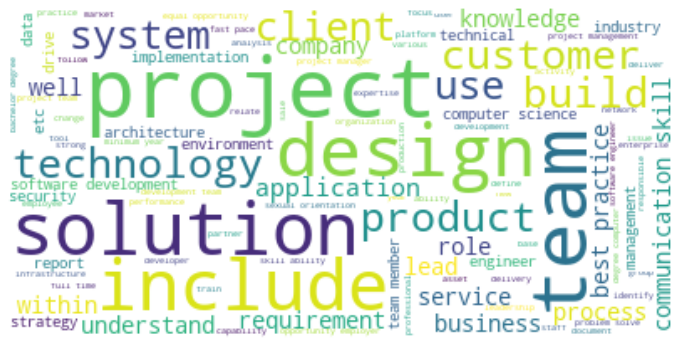

In [11]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(one_giant_text_string)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
# Build 1-, 2-, 3-gram models
keywords = get_ngrams(1)
key_phrases1 = get_ngrams(2)
key_phrases2 = get_ngrams(3)

In [13]:
def get_words_and_counts(vector):
    words = []
    counts = []
    for x in vector:
        words.append(x[0])
        counts.append(x[1])
    return words, counts

def barh_plotter(words, counts):
    sns.set(style='whitegrid', font_scale=1.5)
    sns.color_palette("RdBu", n_colors=7)
    fig, ax = plt.subplots(figsize=(13,8))
    ax = sns.barplot(x='Count',y='Word',data=pd.DataFrame({'Word':words,'Count':counts}))
    
    ax.set_ylabel('Keywords')
    ax.set_xlabel('Frequency')
    return ax


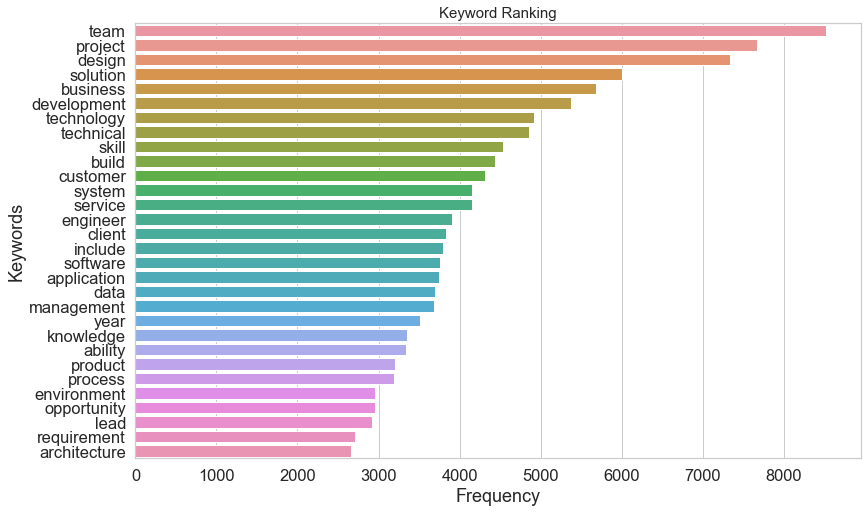

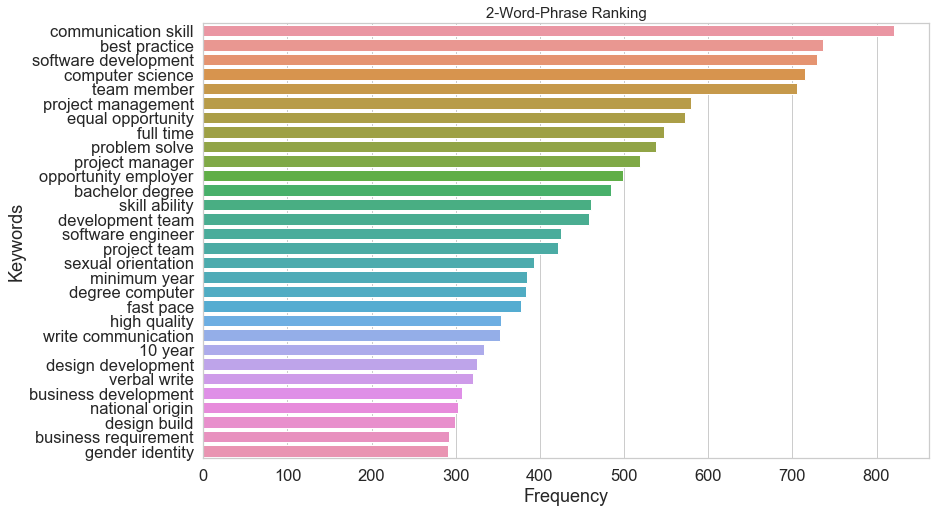

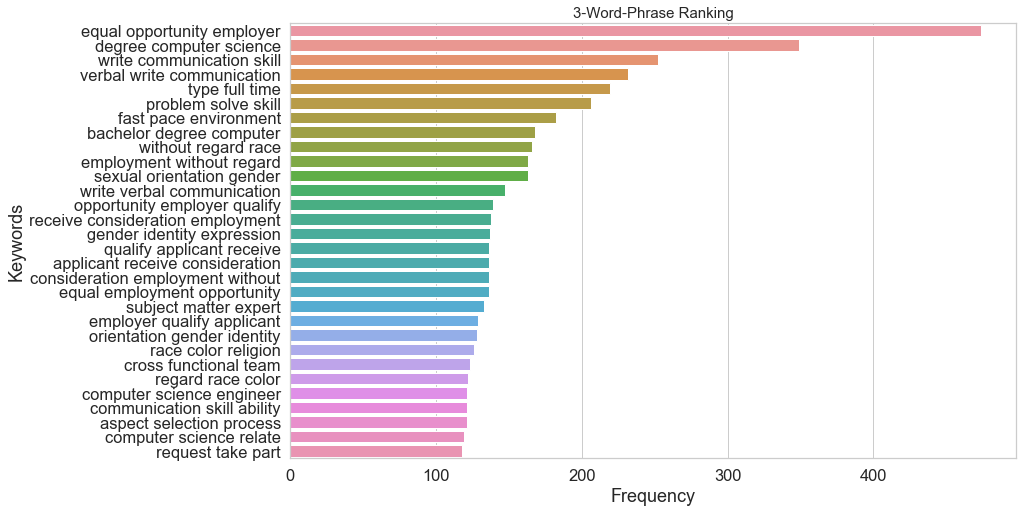

In [14]:
# Keywords
words, counts = get_words_and_counts(keywords)
ax = barh_plotter(words, counts)
ax.set_title('Keyword Ranking',fontsize=15)
plt.show()

# Key phrases
words, counts = get_words_and_counts(key_phrases1)
ax = barh_plotter(words, counts)
ax.set_title('2-Word-Phrase Ranking',fontsize=15)
plt.show()

words, counts = get_words_and_counts(key_phrases2)
ax = barh_plotter(words, counts)
ax.set_title('3-Word-Phrase Ranking',fontsize=15)
plt.show()

## Part IV. Dimensionality Reduction and Clustering


In [15]:
# TF-IDF vectorizer with bigrams
text = list(df['Description'].values)
tfidf = CountVectorizer(ngram_range=(1,2))
# tfidf = TfidfVectorizer(ngram_range=(1,2))
X = tfidf.fit_transform(text)
X.shape, type(X)


((2097, 236257), scipy.sparse.csr.csr_matrix)

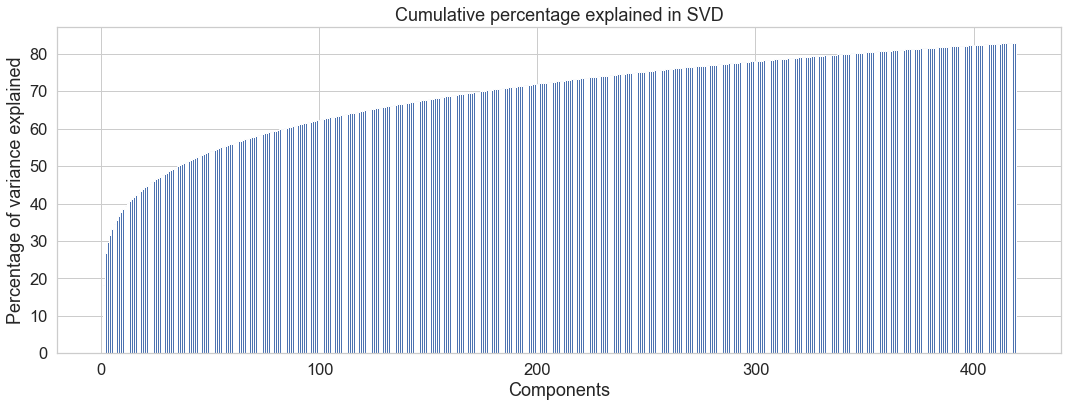

In [16]:
N = int(0.2*X.shape[0])
svd = TruncatedSVD(n_components=N, random_state=42).fit(X.transpose())
plt.figure(figsize=(18,6))
plt.bar(range(1,N+1,1), np.cumsum(100*svd.explained_variance_ratio_))
plt.ylabel('Percentage of variance explained')
plt.xlabel('Components')
plt.title('Cumulative percentage explained in SVD')
plt.show()

Clearly, the number of components used above explain enough variability of the original feature space despite being smaller by more than half. This also has the additional benefit of making T-SNE much faster (a nonlinear dimensionality reduction technique which we clearly need based on the numbers directly above).

In [ ]:
%%time
# Dimensionality reduction using TSNE
X_svd = svd.transform(X.transpose())

kl = {}
embedding = {} # #words x #components
progress = 0

p=30
tsne = TSNE(n_components=2, perplexity=p, random_state=42, n_jobs=-1).fit(X_svd) # default hyperparameters
embedding[p] = tsne.embedding_
kl[p] = tsne.kl_divergence_
    

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
X_embedded = embedding[p]
ax.scatter(X_embedded[:,0], X_embedded[:,1], s=1)
ax.set_ylabel('x$_2$')
ax.set_xlabel('x$_1$')
ax.set_title('TSNE Embedding (Perplexity='+str(p)+')')
plt.show()


In [ ]:
%%time

# Fit DBSCAN (find appropriate hyperparameters based on the plots above)
opt_p = p
X_embedded = embedding[opt_p]
dbscan = DBSCAN(eps=1.5, n_jobs=-1).fit(X_embedded) 
ids = dbscan.labels_
    

Now we plot color-coded clusters on TNSE embedding.

In [ ]:
fig, ax = plt.subplots(figsize=(9,9))
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=ids.astype(float), s=1)
ax.set_ylabel('x$_2$')
ax.set_xlabel('x$_1$')
ax.set_title('Clustered TSNE Embedding (Perplexity='+str(opt_p)+')')
plt.show()


## Part V. Visualize with Real Word Annotations

The original TSNE embedding just has too many data points to annotate with realy words as text. Here, a few clusters are presented separately with actual word annotations.

In [ ]:
# Get clusters by "zone"
zone = [(-50,50), (-50,50)] # x,y limits

idx = (X_embedded[:,0]>=zone[0][0])\
      &(X_embedded[:,0]<=zone[0][1])\
      &(X_embedded[:,1]>=zone[1][0])\
      &(X_embedded[:,1]<=zone[1][1])


In [ ]:
fig, ax = plt.subplots(figsize=(40,40))

#idx = ids==-1
sub_X = X_embedded[idx,:]
ax.scatter(sub_X[:,0], sub_X[:,1], alpha=0.5, c=ids[idx].astype(float))
ax.set_ylabel('x_2')
ax.set_xlabel('x_1')
ax.set_title('TSNE Embedding (Cluster ID: '+str(c)+')')
list_coords = []
for (w,j) in tfidf.vocabulary_.items():
    if idx[j]==False:
        continue
    curr_coord = np.array((X_embedded[j,0], X_embedded[j,1]))
    if len(list_coords)==0:
        ax.annotate(w, curr_coord, rotation=0, fontsize=18) # Annotate with real words
        list_coords.append(curr_coord)
    else:
        # Find if previously occupied coordinates is "too close"
        euc_dist = np.array([np.sqrt((curr_coord-z).T@(curr_coord-z)) for z in list_coords])
        condition = euc_dist <= 1.5
        if sum(condition) > 0:
            continue
        else:
            ax.annotate(w, curr_coord, rotation=0, fontsize=18) # Only annotate "non-overlapping points"
            list_coords.append(curr_coord)

plt.show()

## Appendix A. Attempt at LDA Topic Modeling (did not get meaningful topics)

In [ ]:
# Build bigram and trigram models
bigram = gensim.models.Phrases(df['Description']) 
trigram = gensim.models.Phrases(bigram[df['Description']])  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [ ]:
%%time
run = 0
if run:
    df_lda = make_bigrams(df['Description']) 

    # Define corpus
    id2word = corpora.Dictionary(df_lda)
    corpus_lda = [id2word.doc2bow(text) for text in df_lda]

    # Optimize LDA model
    scores = {}
    models = {}
    progress = 0
    for K in np.arange(2,15,1):
        print('PROGERSS = {:.2f}%'.format(100*(progress+1)/len(np.arange(3,16,1))), end="\r")
        progress += 1

        lda_model = gensim.models.LdaMulticore(corpus=corpus_lda, id2word=id2word, num_topics=K, random_state=42)
        models[K] = lda_model

        # Compute coherence score
        cm = CoherenceModel(model=lda_model, texts=df_lda, dictionary=id2word, coherence='c_v')
        scores[K] = cm.get_coherence()


In [ ]:
if run:
    fig, ax = plt.subplots(figsize=(9,6))
    ax.plot(list(scores.keys()), list(scores.values()))
    ax.set_ylabel('Coherence score', fontsize=15)
    ax.set_xlabel('Number of topics', fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    plt.show()

In [ ]:
%%time
if run:
    opt_K = 6
    opt_model = models[opt_K]

    # Visualize topics-keywords
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(opt_model, corpus_lda, id2word)
    vis
